In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

df = pd.read_csv('gdrive/My Drive/SLO HACKS/full_set_without_outliers.csv')

# df = pd.read_csv('gdrive/My Drive/SLO HACKS/Anomaly_Data.csv')
# df = pd.read_csv("/Users/kylemaxwell/Desktop/Anomaly_Data.csv")

cleaned = np.load('gdrive/My Drive/SLO HACKS/with_date.npy')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# x_train = cleaned[0:400000]
# x_test = cleaned[400000:]

x_train = cleaned

In [0]:
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2


original_dim = x_train.shape[1]
input_shape = (original_dim, )
latent_dim = 2


class Autoencoder:
  def __init__(self, input_dim, inner_activation):
    self.inner_dim = latent_dim
    self.input_dim = input_dim
    self.encoder_layers = []
    self.encoder_layers.append(Dense(32,activation='relu',name='encoder1'))
    self.encoder_layers.append(Dense(8,activation='relu',name='encoder2'))
    self.encoder_layers.append(Dense(self.inner_dim,activation=inner_activation,name='encoder3') ) #sparse would have regularization on here

    self.decoder_layers = []
    self.decoder_layers.append(Dense(8,activation='relu',name='decoder1'))
    self.decoder_layers.append(Dense(32,activation='relu',name='decoder2'))
    x = input_dim[0]
    for i in range(1,len(input_dim)):
      x = x * input_dim[i]
    self.decoder_layers.append(Dense(x,activation=None,name='decoder3'))
  
  def get_autoencoder(self):
    """ Builds the full autoencoder model with encoder and decoder. """
    inputs = Input(self.input_dim,name='autoencoder_input')
    x = Flatten()(inputs) #no need to flatten?
    for i in range(len(self.encoder_layers)):
      x = self.encoder_layers[i](x)
    for i in range(len(self.decoder_layers)):
      x = self.decoder_layers[i](x)
    outputs = Reshape(self.input_dim)(x)
    return Model(inputs=inputs,outputs=outputs)
  
  def get_encoder(self):
    """ Builds just the encoder model. """
    inputs = Input(self.input_dim,name='encoder_input')
    x = Flatten()(inputs) #no need to flatten?
    for i in range(len(self.encoder_layers)):
      x = self.encoder_layers[i](x)
    return Model(inputs=inputs,outputs=x)
  
  def get_decoder(self):
    """ Builds just the decoder model. """
    embedding = Input((self.inner_dim,),name='decoder_input')
    x = embedding
    for i in range(len(self.decoder_layers)):
      x = self.decoder_layers[i](x)
    outputs = Reshape(self.input_dim)(x)
    return Model(inputs=embedding,outputs=outputs)

autoencoder = Autoencoder(input_shape , 'tanh') # input_dim?, inner_activation

ae_model = autoencoder.get_autoencoder()
encoder_model = autoencoder.get_encoder()
decoder_model = autoencoder.get_decoder()

# TRY ADAM?
ae_model.compile(optimizer='adam', loss='mean_squared_error')
#ae_model.compile(SGD(0.01,momentum=0.9),loss='mean_squared_error') # mse
print(ae_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 23)                0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 23)                0         
_________________________________________________________________
encoder1 (Dense)             (None, 32)                768       
_________________________________________________________________
encoder2 (Dense)             (None, 8)                 264       
_________________________________________________________________
encoder3 (Dense)             (None, 2)                 18        
_________________________________________________________________
decoder1 (Dense)             (None, 8)                 24        
_________________________________________________________________
decoder2 (Dense)             (None, 32)                288       
__________

Train on 440906 samples, validate on 48990 samples
Epoch 1/32
440906/440906 [==============================] - 7s 15us/step - loss: 0.0150 - val_loss: 0.0231
Epoch 2/32
440906/440906 [==============================] - 6s 14us/step - loss: 0.0052 - val_loss: 0.0322
Epoch 3/32
440906/440906 [==============================] - 6s 14us/step - loss: 0.0039 - val_loss: 0.0284
Epoch 4/32
440906/440906 [==============================] - 6s 14us/step - loss: 0.0033 - val_loss: 0.0239
Epoch 5/32
440906/440906 [==============================] - 6s 14us/step - loss: 0.0026 - val_loss: 0.0273
Epoch 6/32
440906/440906 [==============================] - 6s 13us/step - loss: 0.0022 - val_loss: 0.0271
Epoch 7/32
440906/440906 [==============================] - 6s 14us/step - loss: 0.0021 - val_loss: 0.0257
Epoch 8/32
440906/440906 [==============================] - 6s 13us/step - loss: 0.0019 - val_loss: 0.0245
Epoch 9/32
440906/440906 [==============================] - 6s 14us/step - loss: 0.0019 - val

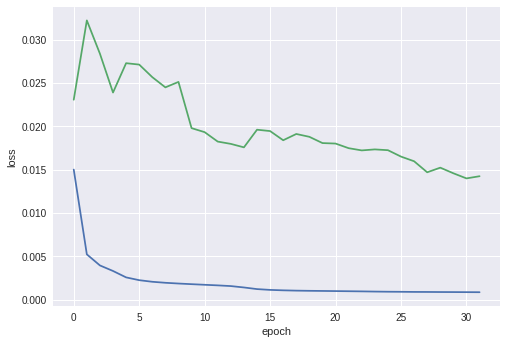

In [0]:
# Training
epochs = 32
batch_size = 128

history = ae_model.fit(x_train,x_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=True,
                       validation_split=0.1)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
# Latent Space Embedding Vis
enc = encoder_model.predict(x_train)


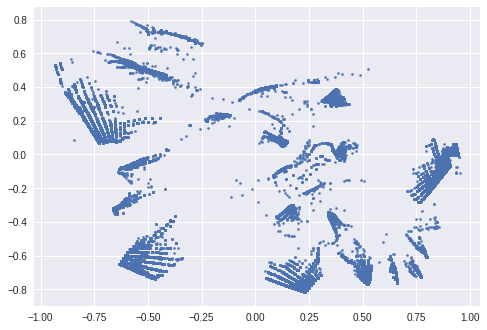

<Figure size 2160x1440 with 0 Axes>

In [0]:
# Data
data = pd.DataFrame()
data['x'] = enc[:,0]
data['y'] = enc[:,1]
plt.scatter(data.x, data.y, s=5.0)
plt.show()

In [0]:
data.to_csv('gdrive/My Drive/SLO HACKS/save_data.csv')

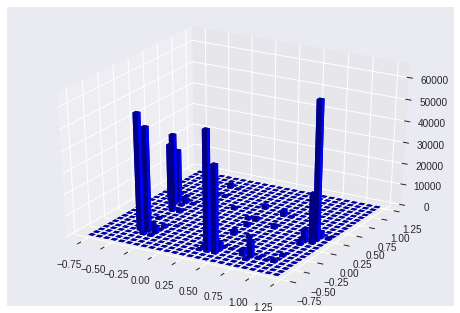

In [0]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = enc[:,0], enc[:,1]

hist, xedges, yedges = np.histogram2d(x, y, bins=25, range=[[-1, 1], [-1, 1]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.05 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

plt.show()


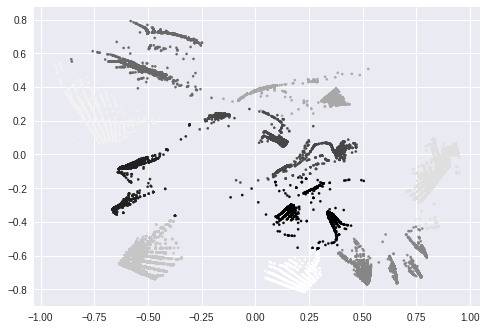

In [0]:
from sklearn.cluster import KMeans
clusters = 10
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(data)

plt.scatter(data.x, data.y, c=kmeans.labels_, s=5.0)
plt.show()



In [0]:
def mean_dist(row): # computationally effcient euclidean distance
    dists = []
    for i in range(clusters):
        x = np.array([row['x'], row['y']])
        y = np.array(kmeans.cluster_centers_[i])
        dist = np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))
        dists.append(dist)              
    return np.around(np.mean(dists), 3)
  
def min_dist(row): # computationally effcient euclidean distance
    dists = []
    for i in range(clusters):
        x = np.array([row['x'], row['y']])
        y = np.array(kmeans.cluster_centers_[i])
        dist = np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))
        dists.append(dist)              
    return np.around(np.min(dists), 3)


In [0]:
# Calculate the dist according to either the min or the mean
data['dist'] = data.apply(min_dist, axis=1)
top_anomalies = data.sort_values(by='dist', ascending=False)

In [0]:
#top_anomalies.head()

In [0]:
from sklearn.neighbors import LocalOutlierFactor

In [0]:
X = data[['x', 'y']]

In [0]:
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).

y_pred = clf.fit_predict(X)
#n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_


array([-1.48134952e+06, -1.00000000e+00, -1.00000000e+00, ...,
       -1.00000000e+00, -1.00000000e+00, -5.33699272e+05])

In [0]:
X_scores

array([-1.48134952e+06, -1.00000000e+00, -1.00000000e+00, ...,
       -1.00000000e+00, -1.00000000e+00, -5.33699272e+05])

In [0]:
data['lof'] = X_scores
top_anomalies = data.sort_values(by='lof', ascending=True)

In [0]:
focus = df[["DC_PROD_NAME", "ORGANIZATION NUMBER", "ACCOUNT_NAME", "TRANSACTION_DATE", "DELIVERED_QUANTITY", "DELIVERED_PRICE", "UNIT_PRICE"]]

In [209]:
focus.describe().T

,count,mean,std,min,25%,50%,75%,max
DELIVERED_QUANTITY,489896.0,1.649864,1.407076,1.00,1.00,1.00,2.00,14.00
DELIVERED_PRICE,489896.0,31.439285,32.110980,0.02,14.71,20.30,36.17,326.65
UNIT_PRICE,489896.0,19.202372,10.326419,0.01,12.90,17.49,22.41,93.06


In [207]:
focus.iloc[top_anomalies.index[:100].values]

,DC_PROD_NAME,ORGANIZATION NUMBER,ACCOUNT_NAME,TRANSACTION_DATE,DELIVERED_QUANTITY,DELIVERED_PRICE,UNIT_PRICE
455453,"TRIGGER,SPRAY,RED&WHT,9.75"" DIP TUBE",WASSER_49,BRINKER TEST KITCHEN,18-OCT-17,10.0,3.10,0.31
455454,"BOTTLE, SPRAY, 32OZ,CENTER NECK,9 3/8""H",WASSER_49,BRINKER TEST KITCHEN,18-OCT-17,10.0,4.00,0.40
422578,BEEF BURGER 8 OZ FRESH,MAINES_1-BRINKER,CHILI'S BRINKER OFFC ACCT,15-JUN-18,4.0,325.84,81.46
477238,CHGS FOR FUEL SURCHARGE,SYSCO006,BRINKER TEST KITCHEN,14-NOV-18,1.0,10.00,10.00
477230,CREPE PLAIN 6,SYSCO013,BRINKER INTERNATIONAL CORP,14-NOV-18,2.0,70.56,35.28
477231,CREPE PLAIN 6,SYSCO013,BRINKER INTERNATIONAL CORP,14-NOV-18,2.0,70.56,35.28
477240,CHICKEN CVP BRST BNLS SKLS ESL,SYSCO006,BRINKER TEST KITCHEN,14-NOV-18,1.0,42.21,42.21
425361,TORTILLA CHIP CORN WHTE,MAINES_1-BRINKER,CHILI'S BRINKER OFFC ACCT,15-SEP-18,13.0,179.79,13.83
425270,TORTILLA CHIP CORN WHTE,MAINES_1-BRINKER,CHILI'S BRINKER OFFC ACCT,15-SEP-18,13.0,179.79,13.83
425479,TORTILLA CHIP CORN WHTE,MAINES_1-BRINKER,CHILI'S BRINKER OFFC ACCT,15-SEP-18,13.0,179.79,13.83


In [0]:
focus.columns

Index(['DC_PROD_NAME', 'ORGANIZATION NUMBER', 'ACCOUNT_NAME',
       'TRANSACTION_DATE', 'DELIVERED_QUANTITY', 'DELIVERED_PRICE',
       'UNIT_PRICE'],
      dtype='object')

In [208]:
focus.iloc[top_anomalies.index[:100].values].iloc[:].values

array([['TRIGGER,SPRAY,RED&WHT,9.75" DIP TUBE', 'WASSER_49',
        'BRINKER TEST KITCHEN', '18-OCT-17', 10.0, 3.1, 0.31],
       ['BOTTLE, SPRAY, 32OZ,CENTER NECK,9 3/8"H', 'WASSER_49',
        'BRINKER TEST KITCHEN', '18-OCT-17', 10.0, 4.0, 0.4],
       ['BEEF BURGER 8 OZ FRESH', 'MAINES_1-BRINKER',
        "CHILI'S BRINKER OFFC ACCT", '15-JUN-18', 4.0, 325.84, 81.46],
       ['CHGS FOR FUEL SURCHARGE', 'SYSCO006', 'BRINKER TEST KITCHEN',
        '14-NOV-18', 1.0, 10.0, 10.0],
       ['CREPE PLAIN 6', 'SYSCO013', 'BRINKER INTERNATIONAL CORP',
        '14-NOV-18', 2.0, 70.56, 35.28],
       ['CREPE PLAIN 6', 'SYSCO013', 'BRINKER INTERNATIONAL CORP',
        '14-NOV-18', 2.0, 70.56, 35.28],
       ['CHICKEN CVP BRST BNLS SKLS ESL', 'SYSCO006',
        'BRINKER TEST KITCHEN', '14-NOV-18', 1.0, 42.21, 42.21],
       ['TORTILLA CHIP CORN WHTE', 'MAINES_1-BRINKER',
        "CHILI'S BRINKER OFFC ACCT", '15-SEP-18', 13.0, 179.79, 13.83],
       ['TORTILLA CHIP CORN WHTE', 'MAINES_1-BRINKER'